# Импорт библиотек

In [1]:
import json
import re

import pandas as pd

import matplotlib.pyplot as plt
from pandas import DataFrame

from wordcloud import WordCloud


# Объединим все данные в один датасет

In [2]:
def open_json(input_file: str) -> dict:
    with open(input_file) as json_file:
        data = json.load(json_file)
    return data

In [3]:
def json_to_csv_lp(json_data: dict) -> DataFrame:
    rows = []
    for category, works in json_data.items():
        for author, work_data in works.items():
            rows.append({
                "title": work_data.get("title", ""),
                "text": work_data.get("text", "")
            })

    df = pd.DataFrame(rows)
    return df

In [4]:
def json_to_csv(json_data: dict) -> DataFrame:
    rows = []
    for title, text in json_data.items():
        rows.append({
            "title": title,
            "text": text
        })

    df = pd.DataFrame(rows)
    return df

clean_data

In [5]:
briefly = open_json("../data/temp_data/json/briefly.json")
litprichal = open_json("../data/temp_data/json/data_litprichal.json")
proza_ru = open_json("../data/temp_data/json/data_proza_ru.json")
litres = open_json("../data/temp_data/json/litres.json")

In [6]:
briefly = json_to_csv(briefly)
litprichal = json_to_csv_lp(litprichal)
proza_ru = json_to_csv_lp(proza_ru)
litres = json_to_csv(litres)

In [7]:
data = pd.concat([briefly, litprichal, proza_ru, litres], ignore_index=True)

In [8]:
data

,title,text
0,"Житие протопопа Аввакума, им самим написанное",Протопоп Аввакум написал житие по благословени...
1,Переписка Андрея Курбского с Иваном Грозным,Князь Андрей Курбский — один из лучших воевод ...
2,Житие Сергия Радонежского,"Преподобный Сергий родился в Тверской земле, в..."
3,Повесть о Петре и Февронии Муромских,В городе Муроме правил князь Павел. К его жене...
4,Моление Даниила Заточника,"«Моление», как и многие другие произведения др..."
...,...,...
32787,Мифические монстры и места их обитания,В этой увлекательной и познавательной книге ав...
32788,Легенда о страшном Змее и наглой девице,Всё пошло не так: девица явилась сама в змеево...
32789,Сказки темной Руси,"Гуляли, значит, по матушке Руси три статных мо..."
32790,"Сезам, откройся!!!","«– Вы начинаете стареть, Иоганн, – ворчливо ск..."


In [9]:
len(briefly) + len(litprichal) + len(proza_ru) + len(litres) - len(data)

0

Никакие данные не потерялись

# Работа с данными

In [10]:
data = data.apply(lambda col: col.str.lower().str.strip())

## Почистим данные от всего лишнего

### Удалим лишние символы

Удалим пропущенные значения

In [11]:
data.isna().sum()

title      0
text     707
dtype: int64

In [12]:
data = data.dropna().reset_index(drop=True)

In [13]:
def clean_text(text):
    """Более аккуратная очистка текста для генерации заголовков"""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"<[^>]+>", "", text)
    text = re.sub(r"[^\w\s,.!?-]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [14]:
data.text = data.text.apply(clean_text)

## Уберем из названий нумерацию (том, эпизод и т.п.)

In [15]:
def clean_title_completely(title):
    """
    Полная очистка названия от всех видов нумерации
    """
    if pd.isna(title):
        return title

    cleaned = str(title).lower().strip()

    complex_patterns = [
        r'\(?\s*\d+\s+(?:эпизод|серия|глава|часть)\s+\d+\s+(?:том|книга|т\.)\s*\d*\s*\.?\)?',
        r'\(?\s*\d+\s+(?:том|книга|т\.)\s+\d+\s+(?:эпизод|серия|глава|часть)\s*\d*\s*\.?\)?',
        r'\b\d+\s+\d+\s+(?:том|часть|книга|эпизод|серия)\b',
        r'\b(?:том|часть|книга|эпизод|серия)\s+\d+\s+\d+\b',
        r'\b\d+[-\.,]\s*\d+\s+(?:том|часть|книга)',
        r'\b(?:том|часть|книга)\s+\d+[-\.,]\s*\d+\b',
    ]

    for pattern in complex_patterns:
        cleaned = re.sub(pattern, '', cleaned, flags=re.IGNORECASE)

    basic_patterns = [
        r'\s*(?:том|часть|книга|т\.|vol\.?|эпизод|серия|глава|выпуск)\s*[ivxlcdm0-9]+',
        r'\s*[ivxlcdm0-9]+\s*(?:том|часть|книга|т\.|vol\.?|эпизод|серия|глава|выпуск)',
        r'\s*\d+[-\.,]?\s*(?:том|часть|книга|глава)',
        r'\s*(?:том|часть|книга|глава)[-\.,]?\s*\d+',
    ]
    for pattern in basic_patterns:
        cleaned = re.sub(pattern, '', cleaned, flags=re.IGNORECASE)

    number_words = [
        "первая", "вторая", "третья", "четвертая", "пятая", "шестая", "седьмая",
        "восьмая", "девятая", "десятая", "одиннадцатая", "двенадцатая", "тринадцатая",
        "четырнадцатая", "пятнадцатая", "шестнадцатая", "семнадцатая", "восемнадцатая",
        "девятнадцатая", "двадцатая"
    ]
    text_num_pattern = r'\b(?:глава|часть|том|эпизод|серия|книга|выпуск)\s+(?:' + "|".join(number_words) + r')\b'
    cleaned = re.sub(text_num_pattern, '', cleaned, flags=re.IGNORECASE)

    cleaned = re.sub(
        r'\b\d+[-–]?(?:я|й|е|ой|ая|ое|ые|ых)?\s+(?:глава|часть|том|книга|серия|эпизод|выпуск)\b',
        '', cleaned, flags=re.IGNORECASE
    )
    cleaned = re.sub(
        r'\b(?:глава|часть|том|книга|серия|эпизод|выпуск)\s+\d+[-–]?(?:я|й|е|ая|ое|ые|ых)?\b',
        '', cleaned, flags=re.IGNORECASE
    )

    cleaned = re.sub(r'№', '', cleaned)

    cleaned = re.sub(r'\([^)]*\d+[^)]*\)', '', cleaned)
    cleaned = re.sub(r'\s+\d+\s*\.?$', '', cleaned)
    cleaned = re.sub(r'^\d+\s+', '', cleaned)

    cleaned = re.sub(r'[^\w\s.,!?-]', '', cleaned)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    cleaned = cleaned.strip(' ,.-')

    return cleaned

In [16]:
data["cleaned_title"] = data.title.apply(clean_title_completely)

In [17]:
changed_count = (data.title != data.cleaned_title).sum()
print(f"Изменено названий: {changed_count} из {len(data)}")

Изменено названий: 8666 из 32085


In [18]:
data.describe()

,title,text,cleaned_title
count,32085,32085,32085
unique,29841,30662,28403
top,"просыпаюсь, а ты рядом! дню семьи",,
freq,38,539,58


почему то есть полностью пустые тексты

In [19]:
data.isna().sum()

title            0
text             0
cleaned_title    0
dtype: int64

In [20]:
data = data[data.text != ""].reset_index(drop=True)
data = data[data.title != ""].reset_index(drop=True)

In [21]:
data.describe()

,title,text,cleaned_title
count,31546,31546,31546
unique,29373,30661,27950
top,латырь-камень бел-горюч... сказка?,описание отсутствует,
freq,38,124,54


есть пустые тексты с заглушкой «описание отсутствует», удалим их

In [22]:
data = data[data.text != "описание отсутствует"].reset_index(drop=True)

In [23]:
data.describe()

,title,text,cleaned_title
count,31422,31422,31422
unique,29273,30660,27857
top,латырь-камень бел-горюч... сказка?,"время скачет как ненормальное, ребята. ладно б...",
freq,38,38,54


In [24]:
data.cleaned_title.value_counts().head(20)

cleaned_title
                                                      54
скрытая опасность                                     38
из жизни графомана                                    38
корнеслов. история слов                               38
латырь-камень бел-горюч... сказка?                    38
просыпаюсь, а ты рядом! дню семьи                     38
энцикловикипедия. топонимы                            38
энцикловикипедия. имена                               38
три поколения швондеров и мы выбираем                 36
красноярск глазами московского туриста                34
классика зарубежного рассказа                         26
мысли по поводу                                       25
наследник ссср - фрагмент                             20
сергей степанов. постлюбовь. новый роман              20
выкладка                                              20
тихий дон                                             18
содержание. трудные места библии. жесток ли ветхий    18
классика русского

Почистим строки, в которых есть не русские буквы

In [25]:
def keep_only_russian(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"[^А-Яа-яЁё0-9\s.,!?-]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

data.text = data.text.apply(keep_only_russian)
data.cleaned_title = data.cleaned_title.apply(keep_only_russian)

data = data[(data.text != "") & (data.cleaned_title != "")].reset_index(drop=True)


Заметим, что в названиях часто встречаются пустые названия или состоящие только из символов.

In [26]:
data = data[data.cleaned_title.str.strip() != ""]
noise_titles = ["***"]
data = data[~data.cleaned_title.isin(noise_titles)].reset_index(drop=True)

print(data.cleaned_title.value_counts().head(20))
print(f"Всего примеров после очистки: {len(data)}")

cleaned_title
из жизни графомана                                    38
корнеслов. история слов                               38
энцикловикипедия. топонимы                            38
скрытая опасность                                     38
латырь-камень бел-горюч... сказка?                    38
просыпаюсь, а ты рядом! дню семьи                     38
энцикловикипедия. имена                               38
три поколения швондеров и мы выбираем                 36
красноярск глазами московского туриста                34
классика зарубежного рассказа                         26
мысли по поводу                                       25
наследник ссср - фрагмент                             20
выкладка                                              20
сергей степанов. постлюбовь. новый роман              20
классика русского рассказа                            18
тихий дон                                             18
содержание. трудные места библии. жесток ли ветхий    18
самая длинная ист

## Почистим строки, в которых нет текста и удалим лидирующую пунктуацию

In [27]:
def is_meaningful(text):
    return bool(re.search(r"[А-Яа-яA-Za-z0-9]", text))

def clean_leading_punct(text):
    return re.sub(r"^[^\wА-Яа-я0-9]+", "", text).strip()

In [28]:
data = data[data.text.apply(is_meaningful)].reset_index(drop=True)
data.text = data.text.str.replace(r"[^\w\s,.!?-]", " ", regex=True)
data.text = data.text.str.replace(r"\s+", " ", regex=True).str.strip()
data.describe()

,title,text,cleaned_title
count,31189,31189,31189
unique,29062,30427,27562
top,скрытая опасность,-история слов. энцикловикипедия посвящается ми...,корнеслов. история слов
freq,38,38,38


## Посмотрим на дубликаты

In [29]:
data.duplicated().sum()

np.int64(430)

In [30]:
data.text.duplicated().sum(), data.title.duplicated().sum()

(np.int64(762), np.int64(2127))

Заметим, что есть дубликаты в названиях, но это нормально, так как парсились разные сайты, на которых могли быть одни и те же произведения. Такое можно оставить.

Но есть дубликаты в тексте, причем большинство из них такие, что текст одинаковый, а названия разные. Такое нужно удалять, это создаст лишний шум для модели.

In [31]:
data = data[~data.text.duplicated(keep=False)].reset_index(drop=True)

In [32]:
data.duplicated().sum()

np.int64(0)

In [33]:
data.describe()

,title,text,cleaned_title
count,30177,30177,30177
unique,28520,30177,27220
top,встреча,протопоп аввакум написал житие по благословени...,классика зарубежного рассказа
freq,12,1,26


In [34]:
data.drop(columns=["title"], inplace=True)

In [35]:
data.rename(columns={"cleaned_title": "title"}, inplace=True)

In [36]:
data.to_csv("../data/temp_data/all_data_cleaned.csv", index=False)

# Анализ длины слов в названиях

In [37]:
title_counts = data.title.value_counts()
title_counts.head(10)

title
классика зарубежного рассказа               26
наследник ссср - фрагмент                   20
выкладка                                    20
сергей степанов. постлюбовь. новый роман    20
тихий дон                                   18
классика русского рассказа                  18
самая длинная история на свете              17
-                                           15
.                                           15
встреча                                     14
Name: count, dtype: int64

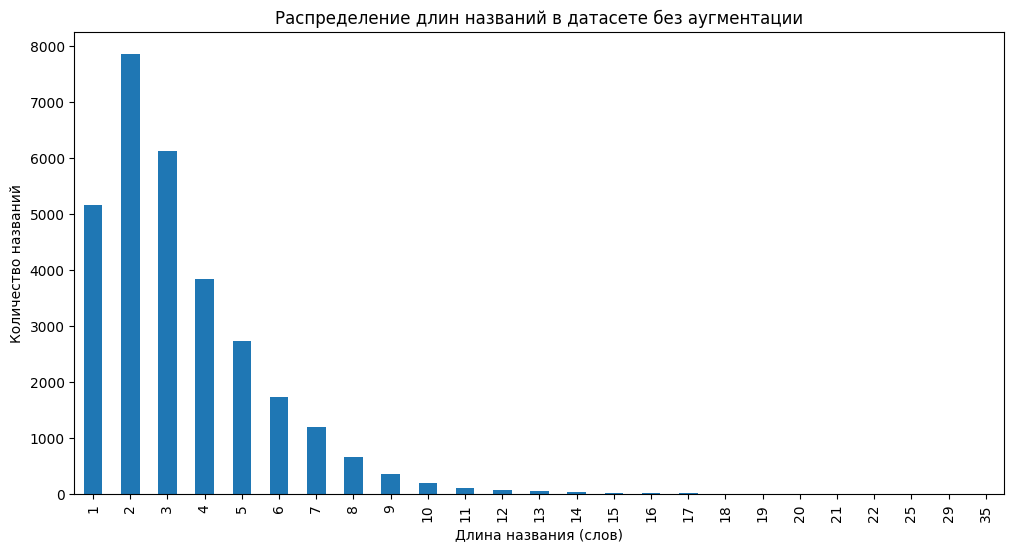

In [38]:
data["title_len"] = data.title.apply(lambda x: len(str(x).split()))

length_counts = data.groupby('title_len').size()

plt.figure(figsize=(12,6))
length_counts.plot(kind='bar')
plt.xlabel("Длина названия (слов)")
plt.ylabel("Количество названий")
plt.title("Распределение длин названий в датасете без аугментации")
plt.show()

Заметно, что есть названия с большим количеством слов. Это внесет в модель шум, поэтому стоит удалить их.

In [39]:
data.describe(include="O")

,text,title
count,30177,30177
unique,30177,27220
top,протопоп аввакум написал житие по благословени...,классика зарубежного рассказа
freq,1,26


In [40]:
data = data[data.title_len <= 10].reset_index(drop=True)

In [41]:
data.describe(include="O")

,text,title
count,29815,29815
unique,29815,26860
top,протопоп аввакум написал житие по благословени...,классика зарубежного рассказа
freq,1,26


In [42]:
data['text_len'] = data.text.str.split().apply(len)

In [43]:
print("Всего примеров:", len(data))
print("Уникальные заголовки:", data.title.nunique())
print("Средняя длина текста:", data.text_len.mean())
print("Средняя длина заголовка:", data.title_len.mean())

Всего примеров: 29815
Уникальные заголовки: 26860
Средняя длина текста: 1931.0041925205433
Средняя длина заголовка: 3.2636256917658897


In [44]:
data.head()

,text,title,title_len,text_len
0,протопоп аввакум написал житие по благословени...,"житие протопопа аввакума, им самим написанное",6,2054
1,князь андрей курбский один из лучших воевод ца...,переписка андрея курбского с иваном грозным,6,1359
2,"преподобный сергий родился в тверской земле, в...",житие сергия радонежского,3,2056
3,в городе муроме правил князь павел. к его жене...,повесть о петре и февронии муромских,6,852
4,"моление , как и многие другие произведения дре...",моление даниила заточника,3,223


In [45]:
data.drop(columns=["title_len", "text_len"], inplace=True)

In [46]:
data.to_csv("../data/all_data.csv", index=False)

# Посмотрим на облако слов

In [47]:
all_titles = " ".join(data.title.astype(str))

wordcloud = WordCloud(
    width=1200, height=600,
    background_color="white",
    max_words=400,
    colormap="viridis",
    collocations=False,
).generate(all_titles)

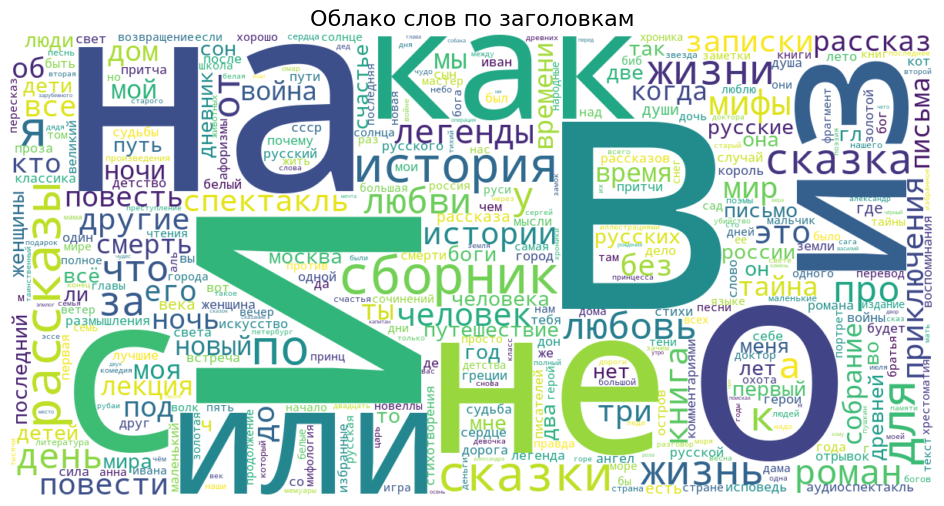

In [48]:
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Облако слов по заголовкам", fontsize=16)
plt.show()

Заметно, что самые популярные слова — предлоги, союзы и т.п., что логично. Их можно убрать, но оставим, чтобы модель училась генерировать названия, приближенные к реальности.